In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import re
import hashlib
import numpy as np

In [2]:
data = pd.read_csv("report_step_1.csv")
data.head()

,id,commit,build,exec_time,comment,fix,lastFix
0,0,687b2e6,SUCCESS,9.0,LANG-747 NumberUtils does not handle Long Hex ...,{'lastFix': None},NaN
1,1,2c454a4,SUCCESS,8.0,LANG-837 Add ObjectUtils.toIdentityString meth...,{'lastFix': None},NaN
2,2,47d5974,SUCCESS,8.0,short circuit (un)capitalize if string is alre...,{'lastFix': None},NaN
3,3,6b5acb4,SUCCESS,8.0,Add tests for new Javadoc examples,{'lastFix': None},NaN
4,4,de63ae7,SUCCESS,8.0,Clarify Javadoc,{'lastFix': None},NaN


## Calculamos el número de builds de cada tipo

In [3]:
data[(data['build'] == 'SUCCESS')].count()

id           1822
commit       1822
build        1822
exec_time    1822
comment      1822
fix          1822
lastFix         0
dtype: int64

In [4]:
data[(data['build'] == 'FAIL')].count()

id           1178
commit       1178
build        1178
exec_time    1178
comment      1178
fix          1178
lastFix         0
dtype: int64

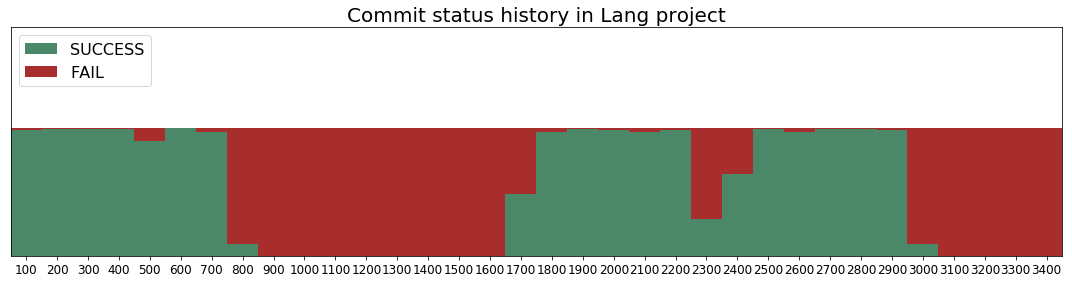

In [5]:
def plot_histogram(total_commits, jump, limit, title):
    fails_list=[]
    success_list=[]
    for index, row in data.iterrows():
        if row['build'] == "SUCCESS":
            success_list.append(row['id'])
        else:
            fails_list.append(row['id'])

    bins = np.arange(0,total_commits,jump)

    fig, ax = plt.subplots(figsize=(15, 4))
    _, bins, patches = plt.hist([np.clip(success_list, bins[0], bins[-1]),
                                 np.clip(fails_list, bins[0], bins[-1])],
                                normed=1,  # normed is deprecated; replace with density
                                stacked=True,
                                #density=True,
                                bins=bins, color=['#4b8869', '#a82e2e'], label=['SUCCESS', 'FAIL'])
    
    xlabels = bins[1:].astype(str)
    xlabels[-1] += '+'

    N_labels = len(xlabels)
    
    plt.xticks(jump * np.arange(N_labels) + jump/2)
    ax.set_xticklabels(xlabels)

    plt.yticks([])
    plt.title(title, fontsize=20)
    plt.setp(patches, linewidth=0)
    plt.legend(loc='upper left', prop={'size': 16})

    fig.tight_layout()
    plt.xlim([0, limit])
    plt.tick_params(axis='both', labelsize=12)
    
    plt.savefig('success_fail_hist.png')
    plt.show()
plot_histogram(3600,100,3400, "Commit status history in Lang project")

## Recogemos todos los fails y los separamos en grupos

In [6]:
import csv

with open("report_step_1.csv") as csvfile:
    reader = csv.DictReader(csvfile)
    csvDict = dict()
    for row in reader:
        csvDict[row['commit']] = row

In [7]:
groups_of_fails = []
fails = []
current_group = []
for k,v in csvDict.items():
    if v['build'] == "SUCCESS" and len(current_group)>0:
        groups_of_fails.append(current_group)
        current_group = []
    if v['build'] == "FAIL":
        current_group.append(v)
        fails.append(v)
if len(current_group)>0:
    groups_of_fails.append(current_group)

In [8]:
moreThan100 = []
for g in groups_of_fails:
    if len(g) > 100:
        moreThan100.append(g)

In [9]:
len(groups_of_fails)

36

## Obtenemos los logs de cada commit con build fail

In [10]:
for fail in fails:
    with open("logs/%s-%s.log"%(fail['id'], fail['commit'])) as f: 
        r_data = f.read()
        fail['log'] = r_data

## Agrupamos los commits por sus logs

In [11]:
def cleanLog(text):
    return text.replace('\n', ' ').replace('\t', ' ')

In [12]:
errors=dict()
def addError(error_type, error_text, commit):
    hash_object = hashlib.md5(error_text.encode())
    hash_key = hash_object.hexdigest()
    if hash_key in errors:
        errors[hash_key]['count'] +=1
        errors[hash_key]['commits'].append(commit)
    else:
        errors[hash_key] = {
            'key': hash_key,
            'type': error_type,
            'message': cleanLog(error_text),
            'commits': [commit],
            'count': 1
        }
    

In [13]:
for fail in fails:
    #print("LOG_%s"%fail['id'])
    detected = False
    
    for pom_error in re.finditer('\[ERROR\] (.+)\n(.+)', fail['log']):
        addError("POM_ERROR", pom_error.group(0), fail['commit'])
        detected = True
        break
    if detected: continue
        
    for no_pom_error in re.finditer('there is no POM in this directory', fail['log']):
        addError("NO_POM_ERROR", no_pom_error.group(0), fail['commit'])
        detected = True
        break
    if detected: continue
        
    for encoding_error in re.finditer('unmappable character for encoding UTF8', fail['log']):
        addError("ENCODING_ERROR", encoding_error.group(0), fail['commit'])
        detected = True
        break
    if detected: continue
        
    
    for java_error in re.finditer('error: (.+)\n(.+)', fail['log']):
        addError("JAVA_ERROR", java_error.group(0), fail['commit'])
        detected = True
        break
    if detected: continue
        
    if not detected:
        addError("UNKNOWN_ERROR", fail['log'], fail['commit'])

In [14]:
df = pd.DataFrame.from_dict(errors, orient='index')
df.groupby(['type']).agg({'count': 'sum'})

,count
type,
JAVA_ERROR,323
UNKNOWN_ERROR,855


In [15]:
df.groupby(['key', 'type', 'message']).agg({'count': 'sum'}).sort_values(by=['count'], ascending=False)

,,,count
key,type,message,
90e1ee698db79d515772fc2debfc7851,UNKNOWN_ERROR,Buildfile: build.xml does not exist! Build failed Buildfile: build.xml does not exist! Build failed,826
5395ee2fba90bc797f9ed80e4f51e53c,JAVA_ERROR,error: no suitable method found for append(char[]) [javac] append(cbuf);,105
e99b573825e96596de2d0d1b10fdd70e,JAVA_ERROR,"error: unmappable character for encoding ASCII [javac] {""copy"", ""169""}, // ? - copyright sign",91
2318fdf879152ce2bae416d2ed9a7ba2,JAVA_ERROR,error: annotations are not supported in -source 1.3 [javac] @Override,60
277b12d4c429adda696d2bc5e4c6f1e1,JAVA_ERROR,error: generics are not supported in -source 1.3 [javac] public static final Class<?>[] EMPTY_CLASS_ARRAY = new Class[0];,51
fbc2641451dab38c322a10a2da815348,JAVA_ERROR,error: cannot find symbol [javac] import org.apache.commons.collections.comparators.BooleanComparator;,6
4eef6bdc319f0fcf714175f9a8785efb,JAVA_ERROR,"error: no suitable method found for format(long,String,boolean) [javac] return format(millis, format, true);",2
604b55332fb9cb348b4338f1bea8d042,UNKNOWN_ERROR,Buildfile: /home/ubuntu/bugs/projects/Lang/build.xml clean: BUILD SUCCESSFUL Total time: 0 seconds Buildfile: /home/ubuntu/bugs/projects/Lang/build.xml,2
de367beeb5db832f60b76d75add16442,JAVA_ERROR,error: IDKey is not public in org.apache.commons.lang; cannot be accessed from outside package [javac] import org.apache.commons.lang.IDKey;,2


In [16]:
#json_df = df.to_json("data.json",orient='records')

In [17]:
errors['25fe7d356a79255e6eb2a6bca03a5f19']['commits'][0]

KeyError: '25fe7d356a79255e6eb2a6bca03a5f19'

In [ ]:
csvDict['5ac897ad']

In [ ]:
success_commits = []
for k,v in csvDict.items():
    if v['build'] == "SUCCESS" and len(current_group)>0:
        success_commits.append(v['commit'])
len(success_commits)

In [ ]:
with open('success_commits.txt', 'w') as f:
    for commit in success_commits:
        f.write("%s\n" % commit)